# 1. データの取得  
ダウンロードしたipynbファイルとcsvファイルを自分のGoogleドライブに置く。

In [ ]:
# Google-ColaboratoryからGoogleドライブにアクセスするためのおまじない。

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# csvファイルをダウンロード
import pandas as pd

df = pd.read_csv('drive/My Drive/USDJPY.csv')
df

,datetime,open,high,low,close,volume
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469
...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569


# 2. データの加工
終値と流通量に追加で、ボラティリティと指数移動平均値を用いる。

In [ ]:
def processing_df(df):
  # 日時と時間のcolumnsを追加する
  df['ema_close'] = df['close'].ewm(span=5).mean()
  df['aoc_close'] = df['close'].diff(1)
  df['aoc_close'] = df['aoc_close'].fillna(df['aoc_close'].median())
  df['volume'] = df['volume']
  
  # columnsの位置を変更する
  df = df[['datetime', 'close', 'ema_close', 'aoc_close', 'volume']]
  return df

processing_df = processing_df(df)
processing_df

,datetime,close,ema_close,aoc_close,volume
0,2005-05-07T21:00:00.000000000Z,105.125,105.125000,0.000,254
1,2005-05-08T21:00:00.000000000Z,105.628,105.426800,0.503,34018
2,2005-05-09T21:00:00.000000000Z,105.560,105.489895,-0.068,34363
3,2005-05-10T21:00:00.000000000Z,105.760,105.602092,0.200,36765
4,2005-05-11T21:00:00.000000000Z,106.776,106.052739,1.016,32469
...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,115.362,114.614911,0.681,85666
4996,2022-01-27T22:00:00.000000000Z,115.238,114.822607,-0.124,73707
4997,2022-01-30T22:00:00.000000000Z,115.136,114.927071,-0.102,70090
4998,2022-01-31T22:00:00.000000000Z,114.688,114.847381,-0.448,68569


# 3. データを可視化  
上から、'終値'、'終値のEMA', '終値の変化量', '終値の変化量のEWDF'をプロット。  
特に、'終値'と'終値の5日移動平均値'、 'ボラティリティ'と 'ボラティリティのEWDF'をそれぞれ比較して何のために、EMA、EWDFを求めたのかを考えてもらいたい。

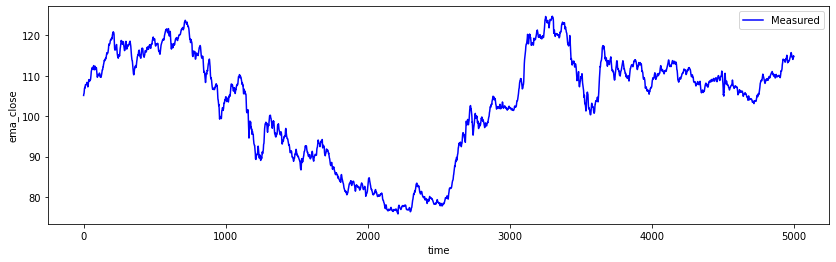

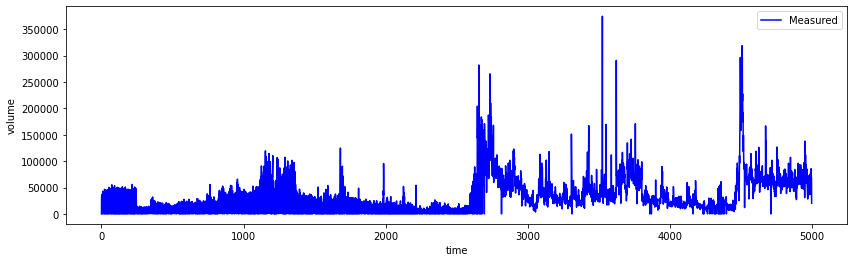

In [ ]:
# from os import X_OK
import matplotlib.pyplot as plt

def show_graph(df, data ,label='close', color="b"):
  X_index = df.index.values
  X = data.values
  plt.figure(figsize=(14, 4))
  plt.xlabel('time')
  plt.ylabel(label)
  plt.plot(X_index, X, color=color, label='Measured')
  plt.legend(loc='upper right')
  plt.show()

show_graph(processing_df, processing_df['ema_close'], 'ema_close')
show_graph(processing_df, processing_df['volume'], 'volume')

In [ ]:
# ema_closeとvolumeを比較する。相関係数を見るとまるで関係がみられない。が、あえて今回はあえてこれを入力として扱う。
# ちなみにcloseとema_closeは非常に関係が似ているが、これら二つを入力に入れた場合はじゃあ結果はどうなるのか。ほぼ同じ入力を2つ入れていることにならないか？

df_corr = df.corr()
df_corr

,open,high,low,close,volume,ema_close,aoc_close
open,1.000000,0.999520,0.999329,0.999032,0.145674,0.999538,-0.020020
high,0.999520,1.000000,0.999039,0.999515,0.155318,0.999484,0.001693
low,0.999329,0.999039,1.000000,0.999488,0.131638,0.999162,0.005374
close,0.999032,0.999515,0.999488,1.000000,0.143803,0.999245,0.023642
volume,0.145674,0.155318,0.131638,0.143803,1.000000,0.146951,-0.044123
ema_close,0.999538,0.999484,0.999162,0.999245,0.146951,1.000000,-0.005328
aoc_close,-0.020020,0.001693,0.005374,0.023642,-0.044123,-0.005328,1.000000


# 4. スケーリング

In [ ]:
# 正規化のためのライブラリ。
from sklearn.preprocessing import MinMaxScaler

def Normalization(data):
  data = pd.DataFrame(data)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  data = scaler.fit_transform(data)
  return scaler, data

# scaler, data = Normalization(df['ema_close'])

# 5. 訓練データと検証データとテストデータに分割  
モデルの精度を検証するためにはデータを**訓練データ**と**テストデータ**に分割する必要がある。

In [ ]:
# 70%で訓練、20%で検証、10%でテストする。

def split_train_valid_test(data):
  train, valid, test = data[0:int(len(data)*0.7),:], data[int(len(data)*0.7):int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
  return train, valid, test

# train, valid, test = split_train_valid_test(data)

# 6. モデルの検証

In [ ]:
# 必要なライブラリをインポート。
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# モデル学習のためのライブラリ
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
# モデルの学習のためのパラメータを指定。

# モデルの学習回数。
epoch_size = 20

look_back=95
output = 5


input = 2

# バッチサイズ
# モデルが1回の処理で使用する件数。
# 一般にbatch_sizeが大きい方が、計算速度が速くなる一方、精度は低下する。
batch_size=1

In [ ]:
def create_dataset(dataset, look_back, output):
  dataX, dataY = [], []
  # iは時間の数
  for i in range(len(dataset)-look_back-output+1):
    xset, yset = [], []
    for j in range(dataset.shape[1]):
      a = dataset[i:(i+look_back), j]
      xset.append(a)

    b = dataset[(i+look_back):(i+look_back)+output]
    yset.append(b)
    dataX.append(xset)
    dataY.append(yset)
  # return np.array(dataX).reshape(len(dataX),look_back,1), np.array(dataY).reshape(len(dataY),output)
  return np.array(dataX), np.array(dataY).reshape(len(dataY),output)

In [ ]:
def arrange_dataset2(df, datalist, look_back, output):
    trainlist = []
    validlist = []
    testlist = []
    for i in range(input):
      scaler, data = Normalization(df[datalist[i]])
      train, valid, test = split_train_valid_test(data)
      trainX, trainY = create_dataset(train, look_back, output)
      validX, validY = create_dataset(valid, look_back, output)
      testX, testY = create_dataset(test, look_back, output)

      trainlist.append(trainX)
      validlist.append(validX)
      testlist.append(testX)

      if i == 0:
        atrainY = trainY
        avalidY = validY
        atestY = testY
        ascaler = scaler        
        adata = data

    trainX = np.concatenate(trainlist, axis=1)
    validX = np.concatenate(validlist, axis=1)
    testX = np.concatenate(testlist, axis=1)
    return trainX, atrainY, validX, avalidY, testX, atestY, ascaler, adata

In [ ]:
trainX, trainY, validX, validY, testX, testY, scaler,data = arrange_dataset2(df, ['ema_close', 'volume'], look_back, output)

In [ ]:
def create_model(input, output):
    model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=(input, look_back)), # 引数の数
    keras.layers.LSTM(20),
    # バッチノーマライゼーションを利用してみたときの結果。
    # activationを指定しなかった場合は、デフォルトのlinear線形関数が使われる。
    keras.layers.Dense(output, activation='tanh')

    
    # keras.layers.Bidirection(LSTM(20, return_sequences=True, input_shape=(input, look_back))), # 引数の数
    # keras.layers.BatchNormalization()
    # keras.layers.Bidirectional(LSTM(64))
    # keras.layers.Dense(output, activation='tanh')

    ])
    
    # model.compile(loss="mse", optimizer="adam")
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model
model = create_model(input, output)

In [ ]:
def build_model(activation , optimizer):
    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=(input, look_back)),
        keras.layers.LSTM(20),
        keras.layers.Dense(output, activation=activation)
      ])
    optimizer = tf.keras.optimizers.RMSprop(0.0008)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

時間がかかるので全部実行はしないが、こんな感じでできる。

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

#グリッドサーチ対象のハイパーパラメーターを準備
activation = ["relu",  "tanh"]
optimizer = ["adam"]
nb_epoch = [10, 20]
batch_size = [1, 10]
#グリッドサーチ対象のハイパーパラメーターを辞書型にまとめる
param_grid = dict(activation=activation, optimizer=optimizer,nb_epoch=nb_epoch, batch_size=batch_size)


# model = KerasRegressor(build_fn = build_model, verbose=2)
model = build_model
#グリッドサーチの実行
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(trainX, trainY)

TypeError: ignored

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import SGD, Adam
# 別のモデルを作成
# LSTMモデルを作成する関数
# def create_LSTM_model(inputer, look_back):
#     input = Input(shape=(inputer, look_back))
#     x = LSTM(64, return_sequences=True)(input)

#     # 学習の勾配消失、爆発を防ぐためのもの。
#     x = BatchNormalization()(x)

#     x = LSTM(64)(x)
#     output = Dense(1, activation='relu')(x)
#     model = Model(input, output)
#     return model

# # Bidirectional-LSTMモデルを作成する関数
# def create_BiLSTM_model(inputer, look_back):
#     input = Input(shape=(inputer, look_back))
#     x = Bidirectional(LSTM(64, return_sequences=True))(input)
#     x = BatchNormalization()(x)
#     x = Bidirectional(LSTM(64))(x)
#     output = Dense(1, activation='relu')(x)
#     model = Model(input, output)
#     return model

In [ ]:
def learning_model(trainX, trainY, validX, validY, epoch_size):
    history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY))
    return history

history = learning_model(trainX, trainY, validX, validY, epoch_size)

In [ ]:
# 一応ここでネスト化されたものが確認できる。

def split_trainvalid_test(data):
  trainvalid, test = data[0:int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
  return trainvalid, test


folds = TimeSeriesSplit(n_splits=2)

def arrange_dataset3(df, datalist, look_back, output):
    scaler, data = Normalization(df[datalist[0]])
    trainvalida, testa = split_trainvalid_test(data)
    for i, (train_index, valid_index) in enumerate(folds.split(trainvalida)):
        trainlist = []
        validlist = []
        testlist = []
        for i in range(input):
          scaler, data = Normalization(df[datalist[i]])
          trainvalid, test = split_trainvalid_test(data)
          trainX, trainY = create_dataset(trainvalid[train_index], look_back, output)
          validX, validY = create_dataset(trainvalid[valid_index], look_back, output)
          testX, testY = create_dataset(test, look_back, output)

          trainlist.append(trainX)
          validlist.append(validX)
          testlist.append(testX)

          if i == 0:
            atrainY = trainY
            avalidY = validY
            atestY = testY
            ascaler = scaler        
            adata = data

        trainX = np.concatenate(trainlist, axis=1)
        validX = np.concatenate(validlist, axis=1)
        testX = np.concatenate(testlist, axis=1)


    history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY), batch_size=batch_size, verbose=2)    
    # return trainX, atrainY, validX, avalidY, testX, atestY, ascaler, adata

In [ ]:
arrange_dataset3(df, ['ema_close', 'volume'], look_back, output)

# 7. モデルの性能評価

In [ ]:
import math
from sklearn.metrics import mean_squared_error

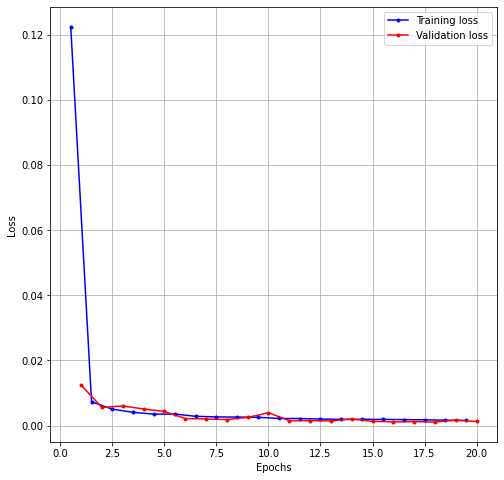

In [ ]:
# 各エポック毎の訓練誤差とテスト誤差を可視化。この結果はさすがにダメすぎる。訓練誤差が発散している。しいて言うならば、エポックサイズ14回が一番いい。

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [ ]:
testPredict = model.predict(testX)

In [ ]:
testPredict.shape

(401, 5)

In [ ]:
testY.shape

(401, 5)

In [ ]:
# testX, testY = create_dataset(test, look_back, output)

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, data, scaler=False):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)

    # 標準化したデータを元に戻す
    if scaler ==False:
      trainPredict = scaler.inverse_transform(pad_array(trainPredict, pad_col))
      trainY = scaler.inverse_transform(pad_array(trainY, pad_col))
      validPredict = scaler.inverse_transform(pad_array(validPredict, pad_col))
      validY = scaler.inverse_transform(pad_array(validY, pad_col))
      testPredict = scaler.inverse_transform(pad_array(testPredict, pad_col))
      testY = scaler.inverse_transform(pad_array(testY, pad_col))
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, data)

Train Score: 0.03 RMSE
Valid Score: 0.03 RMSE
Test Score: 0.03 RMSE


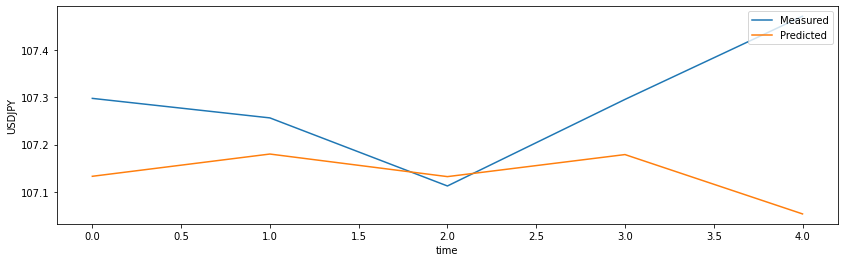

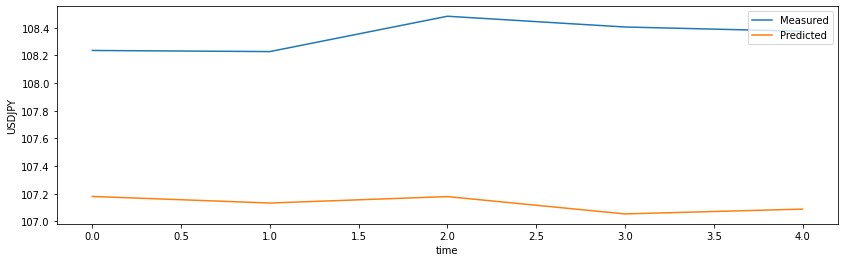

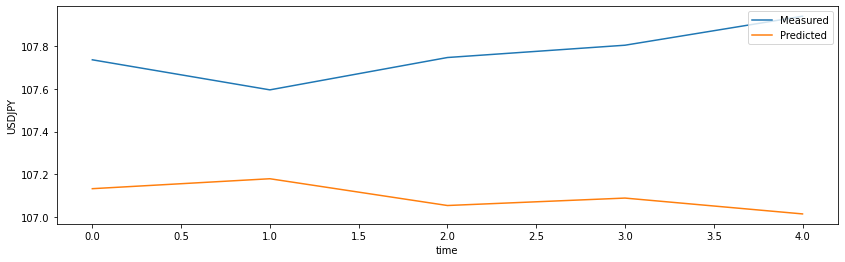

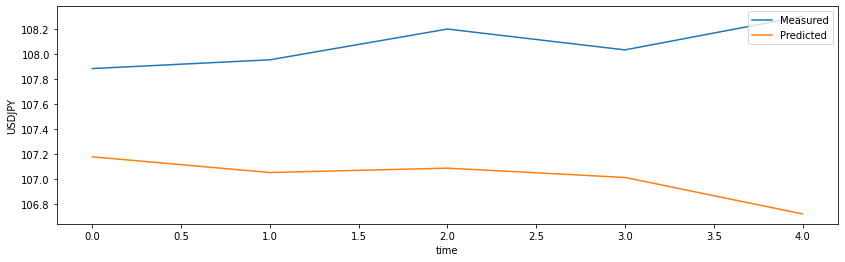

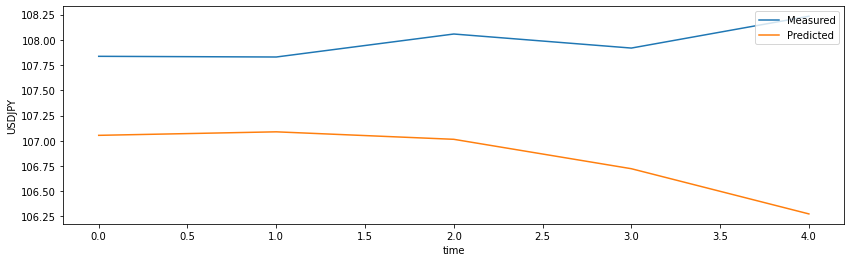

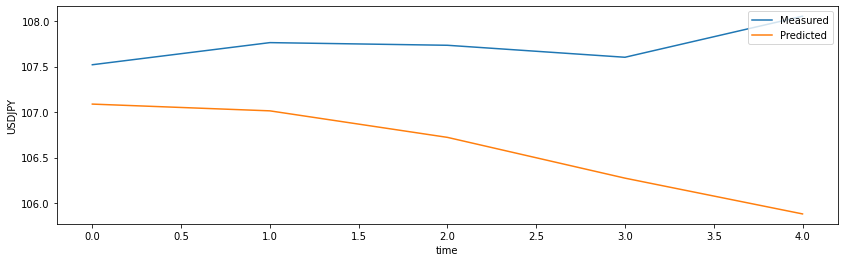

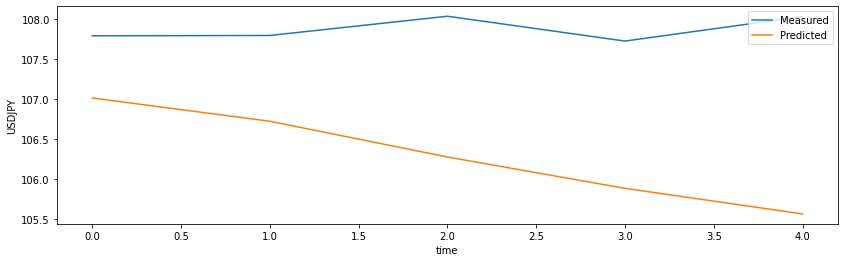

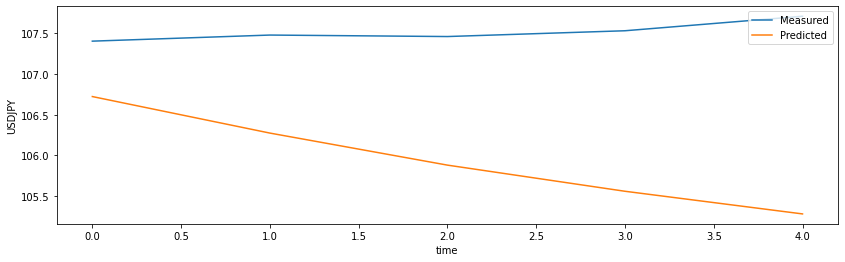

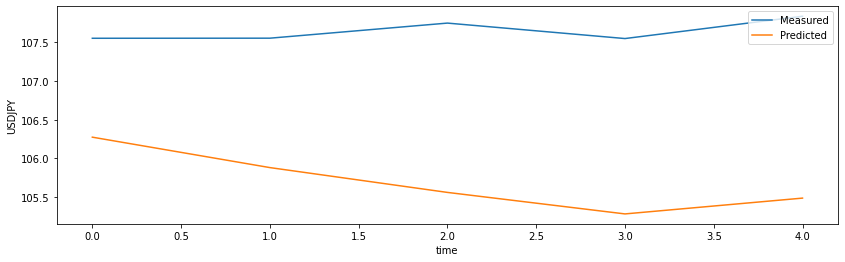

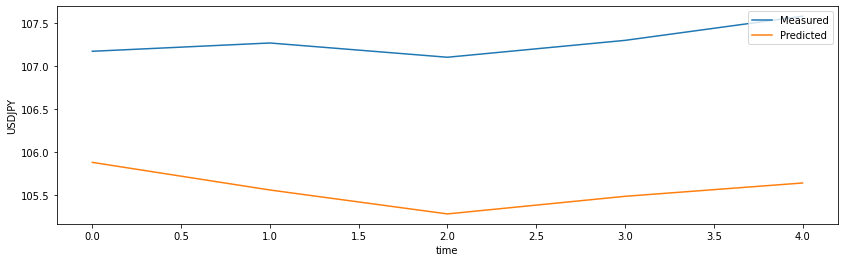

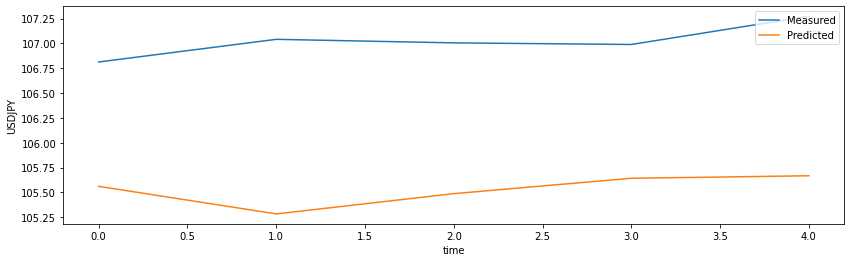

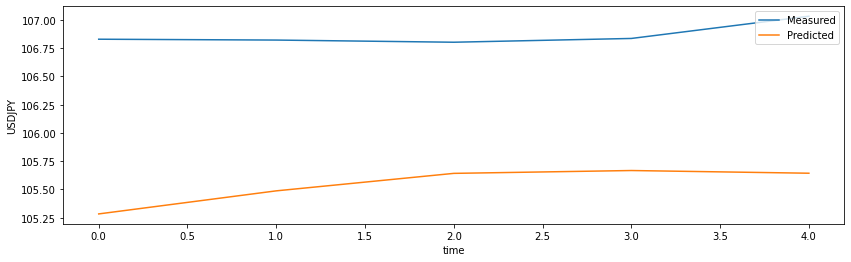

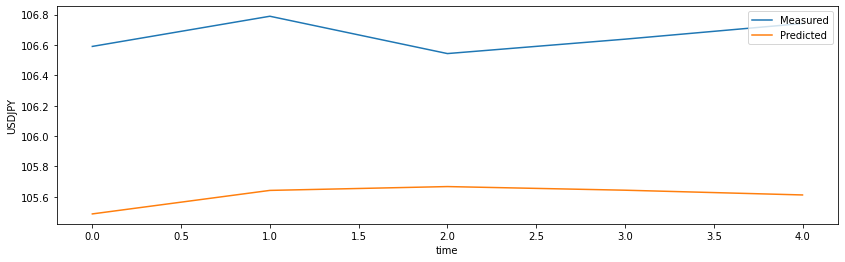

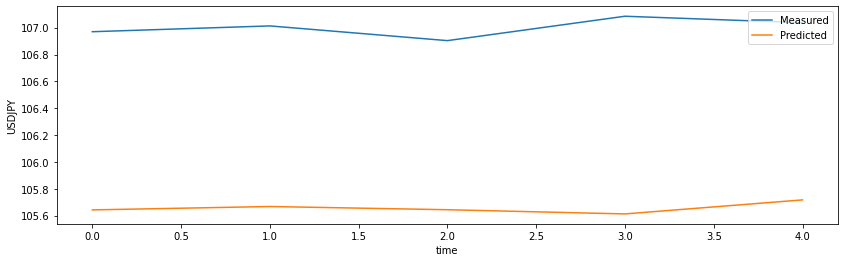

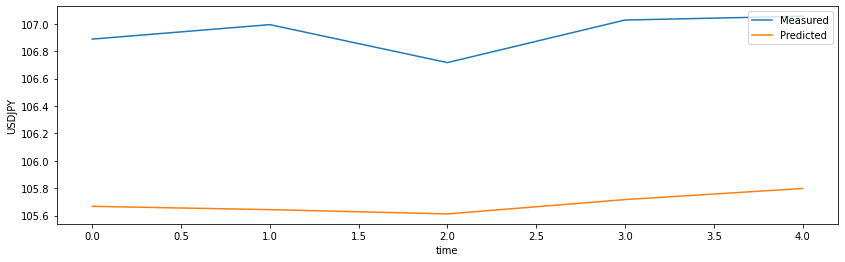

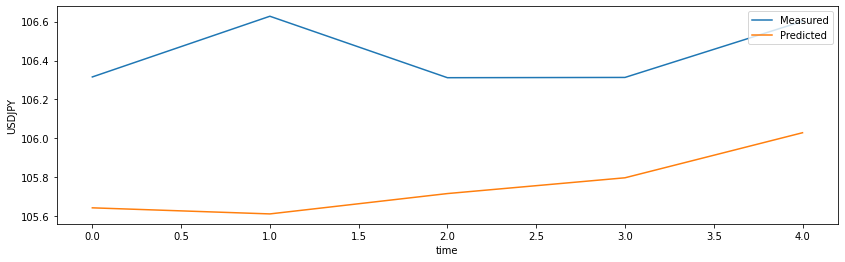

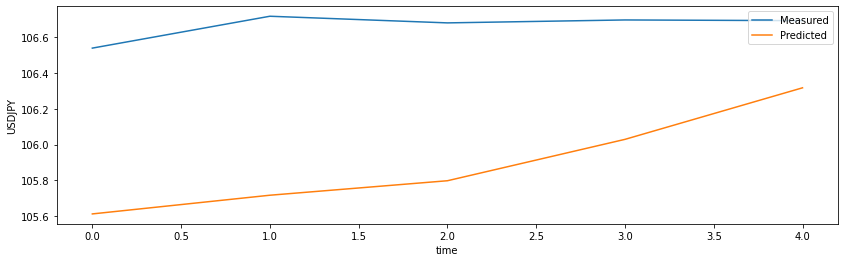

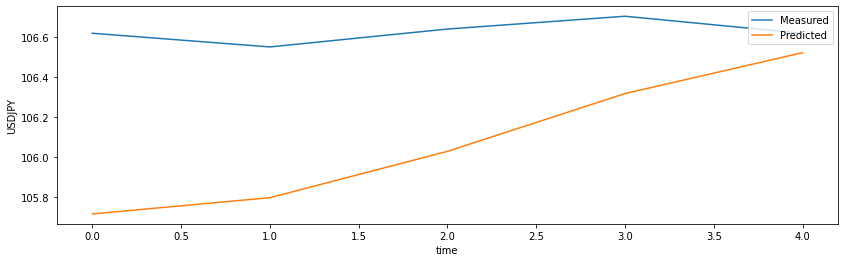

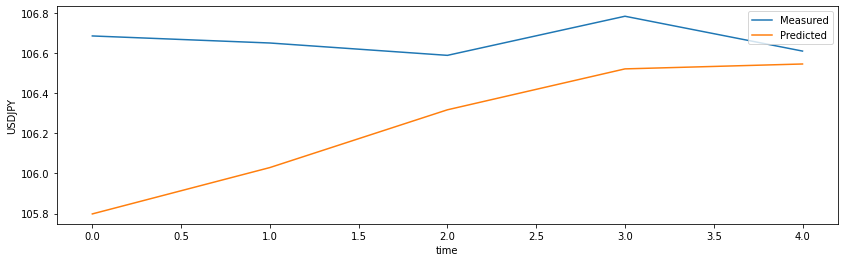

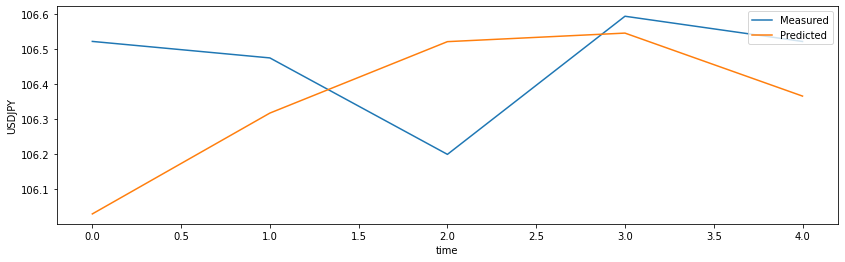

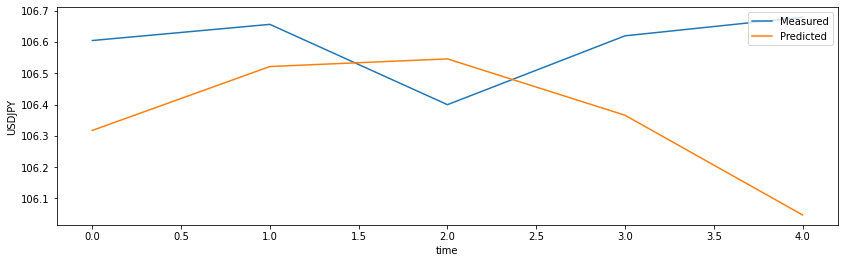

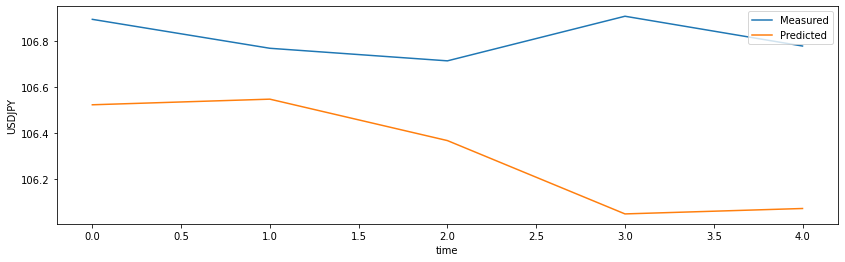

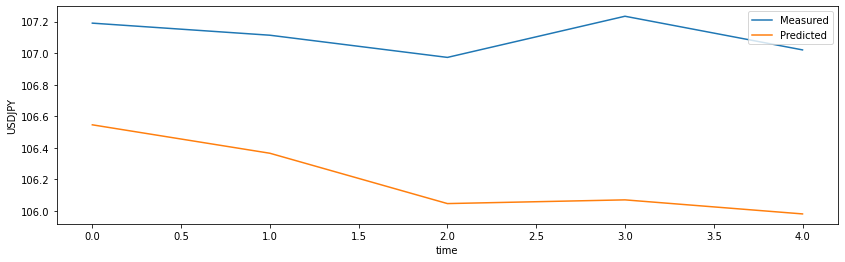

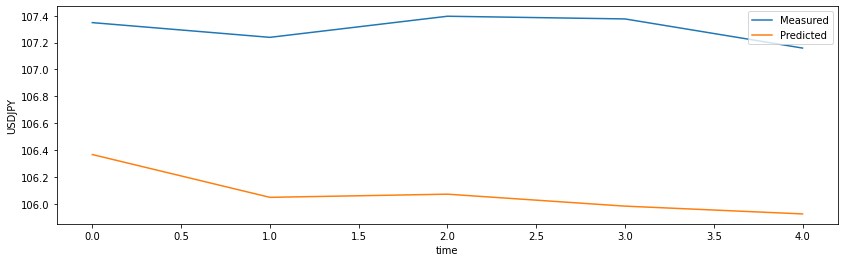

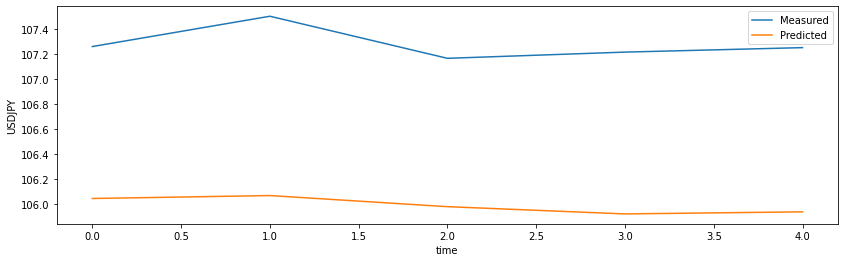

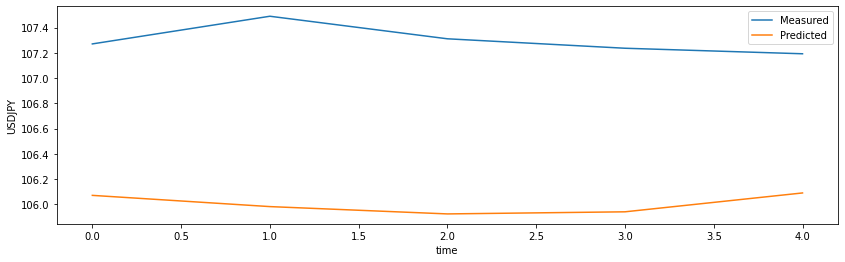

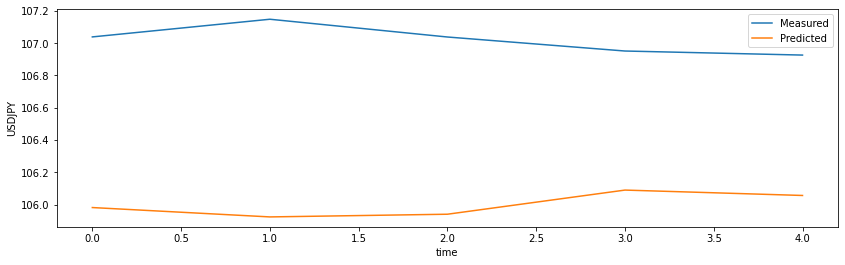

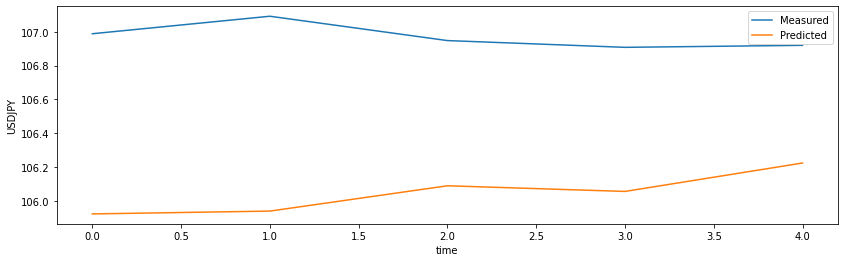

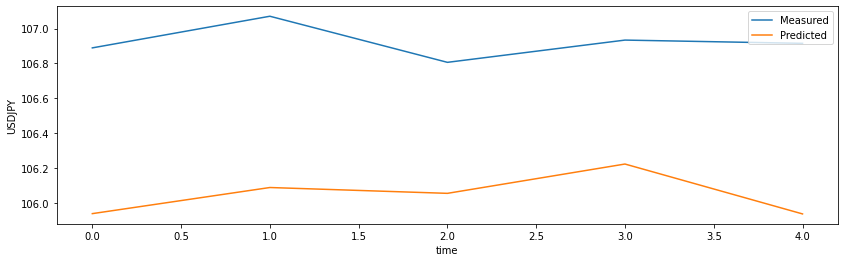

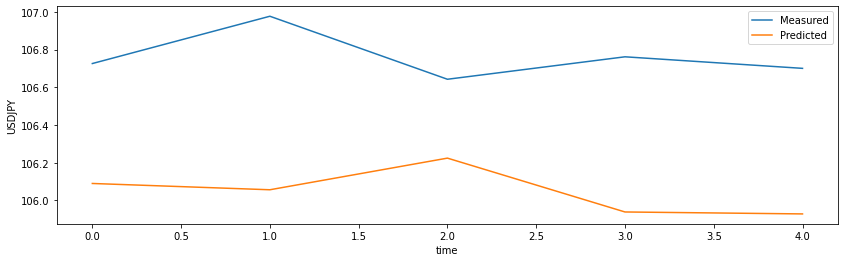

In [ ]:
def test_predictions_for_plotting(testPredict, testY, count):
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    correct = 0
    for i in range(count):
        plt.figure(figsize=(14, 4))
        plt.plot(testPredict[i], label='Measured')
        plt.plot(testY[i], label='Predicted')
        plt.legend(loc='upper right')
        plt.xlabel('time')
        plt.ylabel('USDJPY')
        plt.show()
        if (testPredict[i][4] - testPredict[i][0])*(testY[i][4] - testY[i][0]) > 0:
            correct += 1
    accurate = correct/count
    return accurate

accurate = test_predictions_for_plotting(testPredict, testY, 30)

In [ ]:
accurate

0.4

In [ ]:
# def arrange(lister, data, look_back, output):
#     dataX, dataY = create_dataset(data, look_back, output)
#     lister.append(dataX)
#     return lister

# def arrange_dataset(datalist, input, look_back, output):
#     trainlist = []
#     validlist = []
#     testlist = []
#     for i in range(input):
#       scaler, data = Normalization(datalist[i])
#       train, valid, test = split_train_valid_test(data)
#       # trainX, trainY = create_dataset(train, look_back, output)
#       # validX, validY = create_dataset(valid, look_back, output)
#       # testX, testY = create_dataset(test, look_back, output)
 
#       # trainX = np.concatenate([trainX, trainX], axis=1)
#       # validX = np.concatenate([validX, validX], axis=1)
#       # # testX = np.concatenate([testX, testX], axis=1)
#       # trainlist.append(trainX)
#       # trainlist.append(trainX)
#       # trainlist.append(trainX)
#       trainlist = arrange(trainlist, train, look_back, output)
#       validlist = arrange(validlist, train, look_back, output)
#       testlist = arrange(testlist, train, look_back, output)

#       if i == 0:
#         trainY = trainY
#         validY = validY
#         testY = testY
#     # scaler_b, data_b = Normalization(df['volume'])
#     # train_b, valid_b, test_b = split_train_valid_test(data_b)
#     # trainX_b, trainY_b = create_dataset(train_b, look_back, output)
#     # validX_b, validY_b = create_dataset(valid_b, look_back, output)
#     # testX_b, testY_b = create_dataset(test_b, look_back, output)


#     # trainY = trainY_a
#     # trainY = trainY_a
#     # testY = trainY_a
#     return trainlist, trainY, validlist, validY, testlist, testY
# arrange_dataset([df['ema_close'], df['volume']], input, look_back, output)

In [ ]:
# def arrange_dataset(df, look_back, output):
#     scaler_a, data_a = Normalization(df['ema_close'])
#     train_a, valid_a, test_a = split_train_valid_test(data_a)
#     trainX_a, trainY_a = create_dataset(train_a, look_back, output)
#     validX_a, validY_a = create_dataset(valid_a, look_back, output)
#     testX_a, testY_a = create_dataset(test_a, look_back, output)

#     scaler_b, data_b = Normalization(df['volume'])
#     train_b, valid_b, test_b = split_train_valid_test(data_b)
#     trainX_b, trainY_b = create_dataset(train_b, look_back, output)
#     validX_b, validY_b = create_dataset(valid_b, look_back, output)
#     testX_b, testY_b = create_dataset(test_b, look_back, output)


#     trainX = np.concatenate([trainX_a, trainX_b], axis=1)
#     trainY = trainY_a
#     validX = np.concatenate([validX_a, validX_b], axis=1)
#     validY = validY_a
#     testX = np.concatenate([testX_a, testX_b], axis=1)
#     testY = testY_a
#     scaler = scaler_a
#     data = data_a
#     return trainX, trainY, validX, validY, testX, testY, scaler,data

In [ ]:
# 一応optunaを使って学習をすることはできた。しかしこれで本当にあっているのかは不明なので、要確認。

In [ ]:
pip install optuna

In [ ]:
import numpy as np
import optuna

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils





def create_model(activation):
    model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=(input, look_back)), # 引数の数
    keras.layers.LSTM(20),
    keras.layers.Dense(output, activation=activation)
    ])
    return model



def objective(trial):
    # データをロード
    # x_train, y_train, x_test, y_test = MNIST_data()

    # 調整したいハイパーパラメータの設定
    # n_layer = trial.suggest_int('n_layer', 1, 3) # 追加する層を1-3から選ぶ
    # mid_units = int(trial.suggest_discrete_uniform('mid_units', 100, 500, 1)) # ユニット数
    # dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
    activation = trial.suggest_categorical('activation', ['relu', 'tanh']) # 活性化関数
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam', 'rmsprop']) # 最適化アルゴリズム

    # 学習モデルの構築と学習の開始
    model = create_model(activation)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY), batch_size=batch_size, verbose=2)  
    
    # 学習モデルの保存
    model_json = model.to_json()
    with open('keras_model.json', 'w') as f_model:
        f_model.write(model_json)
    model.save_weights('keras_model.hdf5')

    # 最小値探索なので
    return -np.amax(history.history['val_acc'])
    

study = optuna.create_study(sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-02-07 04:57:35,120] A new study created in memory with name: no-name-5d98e04b-c7b5-421c-a76a-09c08e0889c7


Epoch 1/20
3401/3401 - 16s - loss: 4.2608 - accuracy: 0.0938 - val_loss: 19.9832 - val_accuracy: 0.0766 - 16s/epoch - 5ms/step
Epoch 2/20
3401/3401 - 13s - loss: 4.4132 - accuracy: 0.0797 - val_loss: 19.9832 - val_accuracy: 0.0766 - 13s/epoch - 4ms/step
Epoch 3/20
3401/3401 - 11s - loss: 4.4132 - accuracy: 0.0797 - val_loss: 19.9832 - val_accuracy: 0.0766 - 11s/epoch - 3ms/step
Epoch 4/20
3401/3401 - 10s - loss: 4.4132 - accuracy: 0.0797 - val_loss: 19.9832 - val_accuracy: 0.0766 - 10s/epoch - 3ms/step
Epoch 5/20
3401/3401 - 10s - loss: 4.4132 - accuracy: 0.0797 - val_loss: 19.9832 - val_accuracy: 0.0766 - 10s/epoch - 3ms/step
Epoch 6/20
3401/3401 - 9s - loss: 4.4131 - accuracy: 0.0797 - val_loss: 19.9832 - val_accuracy: 0.0766 - 9s/epoch - 3ms/step
Epoch 7/20


KeyboardInterrupt: ignored